In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from helpers import *
from Model import *
from cross_val import *
%matplotlib inline

# Data cleaning

In [2]:
[yb_t, input_data_t, ids_t, yb_test, input_data_test, ids_test] = pickle.load(open( "dat.p", "rb" ))
# Import full data
#(yb_t, input_data_t, ids_t) = load_csv_data('data/train.csv', sub_sample = False)
#(yb_test, input_data_test, ids_test) = load_csv_data('data/test.csv',sub_sample = False)

# Replace missing data with nan
tx_tr_clean = clean_data(input_data_t)
y_tr_clean = clean_data(yb_t)
tx_te_clean = clean_data(input_data_test)
y_te_clean = clean_data(yb_test)

y_tr_clean = np.array([0 if p<0 else 1 for p in y_tr_clean])
print('Train set shape ', tx_tr_clean.shape)
print('Test set shape ', tx_te_clean.shape)

Train set shape  (250000, 30)
Test set shape  (568238, 30)


# Data processing

In [3]:
# Standardize data
tx_tr, mean_tx_tr, std_tx_tr = standardize(tx_tr_clean)

# Test data should be standardize wt respect to the mean and standard deviation of the training set
tx_te = (tx_te_clean - mean_tx_tr)/std_tx_tr

In [4]:
# Replacing missing values by their respective mean for each feature (computing for the TRAINING set only!)
def replaceByMeanPerFeature(input_tx_train, input_y_train, input_tx_test, input_y_test):
    train_mean = np.nanmean(input_tx_train, axis=0) # Computes the mean per column without considering nan value
    for ind, mean in enumerate(train_mean):
        mask_tmp = np.isnan(input_tx_train[:,ind])
        input_tx_train[mask_tmp, ind] = mean
        mask_tmp = np.isnan(input_tx_test[:,ind])
        input_tx_test[mask_tmp, ind] = mean
    y_train = input_y_train
    y_test = input_y_test
    return input_tx_train, y_train, input_tx_test, y_test

tx_tr, y_tr, tx_te, y_te = replaceByMeanPerFeature(tx_tr_clean, y_tr_clean, tx_te_clean, y_te_clean)

In [5]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly[:, 1:]

def augment_feat(input_tx_train, input_tx_test, degree):
    n_features = len(input_tx_train[0])
    for ind in range(0, n_features):
        input_tx_train = np.c_[input_tx_train, build_poly(input_tx_train[:, ind], degree)]
        input_tx_test = np.c_[input_tx_test, build_poly(input_tx_test[:, ind], degree)]
    return input_tx_train, input_tx_test

# Fit data with Ridge Regression with no feature augmentation

In [6]:
def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")

Wall time: 8.74 s


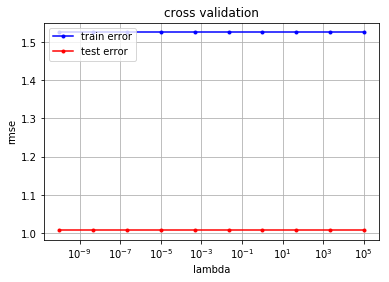

In [9]:
%%time
def cross_validation_demo():
    seed = 1
    degree = 1
    k_fold = 4
    gammas = np.logspace(-9, -7, 20)
    lambdas = np.logspace(-10,5,10)
    
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    # cross validation
    for ind, lambda_ in enumerate(lambdas):
        # define model
        model = logistic_regression_SGD(lambda_ = lambda_, gamma = 5e-8,max_iters = 1)
        losses_train, losses_test = cross_validation_logistic(model, y_tr, tx_tr, k_fold)
        tmp_tr = np.mean(losses_train)
        tmp_te = np.mean(losses_test)
        rmse_tr.append(tmp_tr)
        rmse_te.append(tmp_te)
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

# Fit data with Ridge Regression with data augmentation

In [10]:
tx_tr_in = tx_tr
tx_te_in = tx_te

In [11]:
tx_tr, tx_te = augment_feat(tx_tr_in, tx_te_in, 2)
print("tx_tr.shape = ", tx_tr.shape)
print("tx_te_shape = ", tx_te.shape)

tx_tr.shape =  (250000, 90)
tx_te_shape =  (568238, 90)


In [14]:
%%time

def cross_validation_demo():
    seed = 1
    degree = 1
    k_fold = 4
    gammas = np.logspace(-20, 0, 10)
    lambdas = np.logspace(-10,5,10)
    
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    var = []
    # cross validation
    for ind, lambda_ in enumerate(lambdas):
        for gamma in gammas:
            # define model
            model = logistic_regression_SGD(lambda_ = lambda_, gamma = gamma,max_iters = 1)
            losses_train, losses_test = cross_validation_logistic(model, y_tr, tx_tr, k_fold)
            tmp_tr = np.mean(losses_train)
            tmp_te = np.mean(losses_test)
            rmse_tr.append(tmp_tr)
            rmse_te.append(tmp_te)
            var.append([lambda_,gamma])
    #cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    
    print(np.min(tmp_te))
    print(var[np.argmin(tmp_te)])
cross_validation_demo()

1476213.90553
[1e-10, 9.9999999999999995e-21]
Wall time: 2min 26s


# Fit data with Ridge Regression and augmenting features using log

In [18]:
def build_poly_log(x):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly_log = np.ones((len(x), 1))
    poly_log = np.c_[poly_log, np.sqrt(np.abs(x))]
    return poly_log[:, 1:]

def augment_feat_log(input_tx_train, input_tx_test):
    n_features = len(input_tx_train[0])
    for ind in range(0, n_features):
        input_tx_train = np.c_[input_tx_train, build_poly_log(input_tx_train[:, ind])]
        input_tx_test = np.c_[input_tx_test, build_poly_log(input_tx_test[:, ind])]
    return input_tx_train, input_tx_test

In [19]:
tx_tr, tx_te = augment_feat_log(tx_tr_in, tx_te_in)
print("tx_tr.shape = ", tx_tr.shape)
print("tx_te_shape = ", tx_te.shape)

tx_tr.shape =  (250000, 60)
tx_te_shape =  (568238, 60)


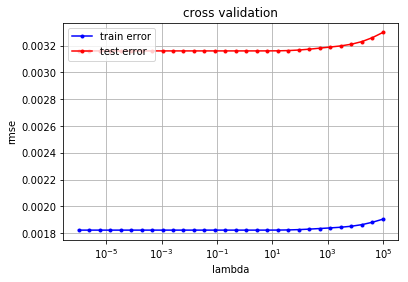

In [20]:
def cross_validation_demo():
    seed = 1
    degree = 1
    k_fold = 4
    gammas = np.logspace(-10, -5, 10)
    
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    # cross validation
    for ind, gammas in enumerate(gammas):
        # define model
        model = ridge_regression(lambda_)
        losses_train, losses_test = cross_validation(model, y_tr, tx_tr, k_fold)
        tmp_tr = np.mean(losses_train)
        tmp_te = np.mean(losses_test)
        rmse_tr.append(tmp_tr)
        rmse_te.append(tmp_te)
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

In [34]:
y_tr_rfdf = np.array([0 if p<0 else 1 for p in y_tr])

In [35]:

model = ridge_regression(1e-5)
model.fit(y_tr_rfdf, tx_tr)
y_pred_test = model.predict(tx_te)

In [36]:
y_pred_bin = np.array([-1 if p<0.5 else 1 for p in y_pred_test])
np.sum(y_pred_bin)

-249514

In [37]:
create_csv_submission(ids_test, y_pred_bin, 'sub3.csv')